# CAQL Stream Operations

In this section we take a step back and review some basic stream operations.

In [2]:
%matplotlib inline
%run preamble.py

## Arithmetic and the op:* package

CAQL supports the usual arithmetic operations: +,-,*,/

They are available as binary operators or via the functions: op:sum(), op:sub(), op:prod(), op:div().

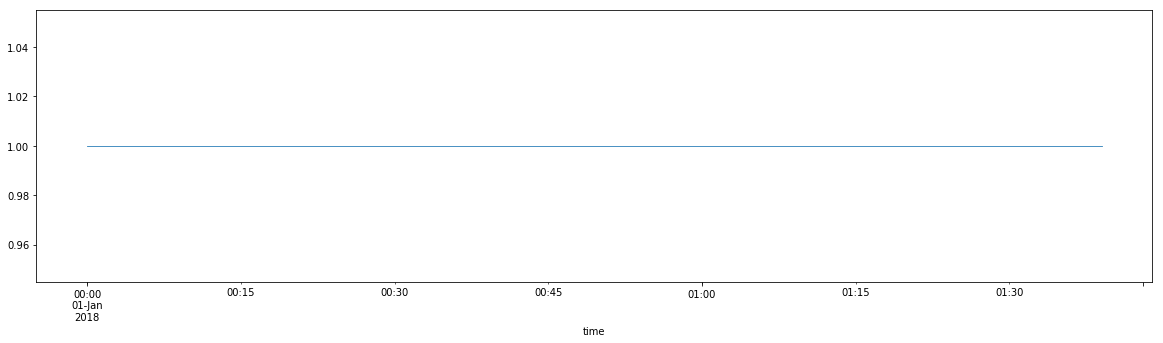

In [3]:
caql_plot('demo', '''

(1 + 2) / 3

''', datetime(2018,1,1), 60, 100)

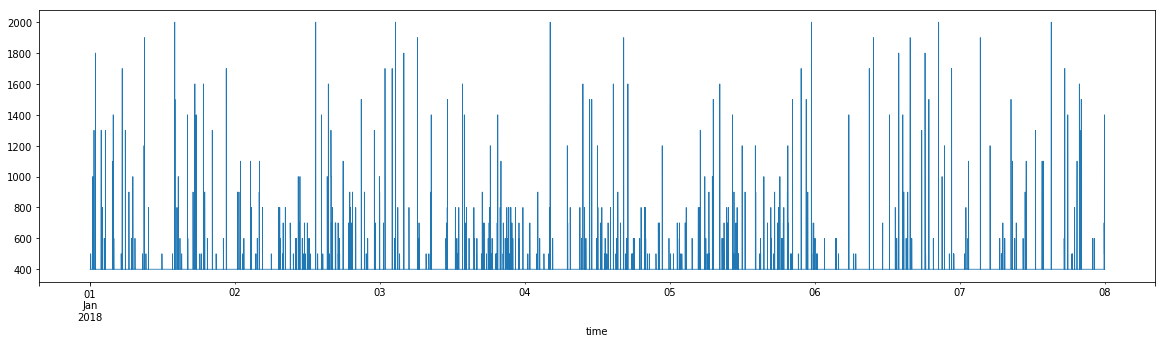

In [12]:
caql_plot("demo",'''

metric:average("673044d5-379a-4037-89e5-c0694ef756ed","duration") + 3 
| op:prod(100)
| stats:min(2000)

''', datetime(2018,1,1), 60, 60*24*7)

## Using `stats:*` vs `op:*`

There are a number of functions that are seeminly duplicated between the `stats:*` and `op:*` pacakges.
One semantic difference is the handling of missing data (pseudo CAQL):
```
(1) op:sum{ NULL, 3 } = NULL + 3 => NULL
(2) stats:sum{ NULL, 3 } => 3
```
If you are aggregating multiple metrics, you most likely want the `stats:*` functions.

## Comparison operators

CAQL Supports the following comparison operators: <, <=, ==, >=, >.

They are also available as functions op:lt(), op:leq(), op:eq(), ... (names lended from `man test`).

The results are boolean values represented as numeric values 0 (false) 1 (true).

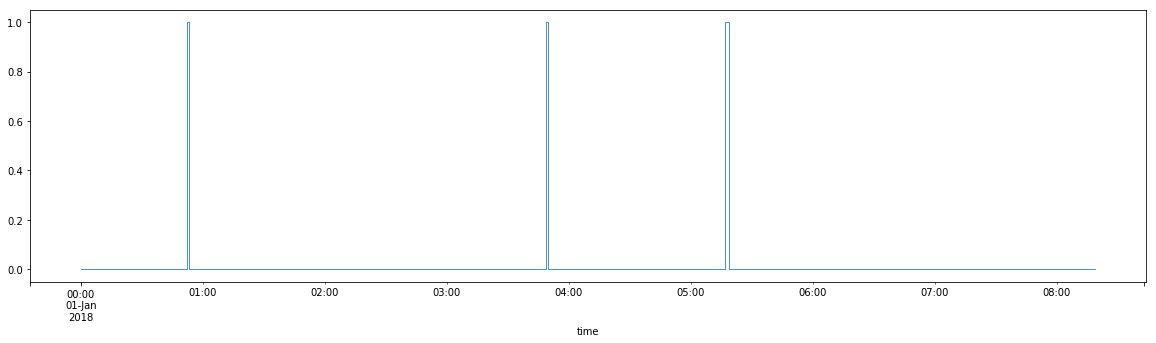

In [18]:
caql_plot("demo", '''

  metric:average("673044d5-379a-4037-89e5-c0694ef756ed","duration") > 10

''', datetime(2018,1,1), 60, 500)

# Boolean Operations

CAQL also supports boolean operators `and`, `or`, `not`/`!`.

## Application: Uptime Reporting

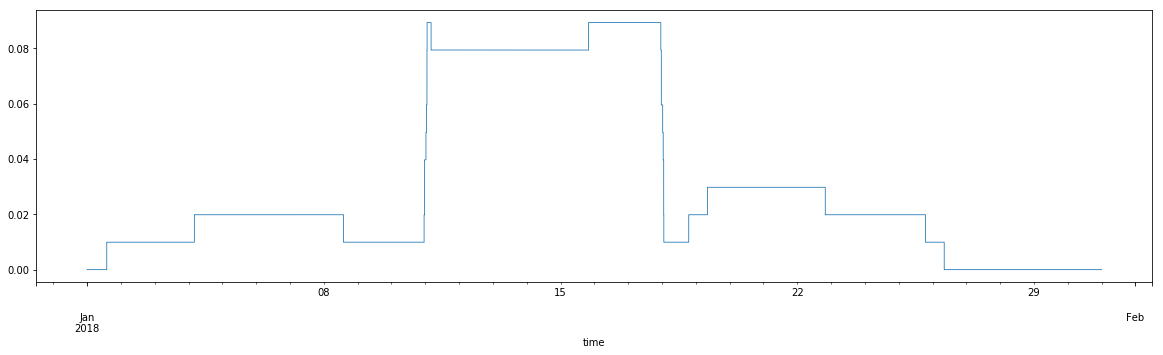

In [22]:
## Count SLA Violation over per day

caql_plot("demo", '''

metric:average("673044d5-379a-4037-89e5-c0694ef756ed","duration") > 50
| rolling:mean(7d)
| op:prod(100)

''', datetime(2018,1,1), 60, 60 * 24 * 30)

## Application: Emulate Alerting Rules

Threshold based alerting rules can be emulated using CAQLs <,> operators.

In order to specify a time to wait before seinding out an alert, you can use the wait() function:

* wait(duration) - Returns 1 if the value has been 1 for a given time duration.

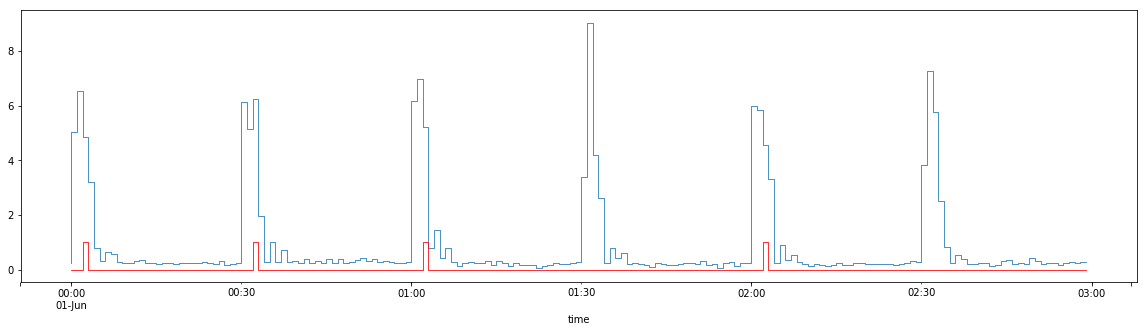

In [62]:
ax1=caql_plot("ops",'''

metric:counter("09a0a30e-e9df-4c79-8ea5-fc2024864874","message_stats`get_no_ack")

''', datetime(2018, 6, 1), 60, 60 * 3)
caql_plot("ops",'''

metric:counter("09a0a30e-e9df-4c79-8ea5-fc2024864874","message_stats`get_no_ack") > 4
| wait(3M) // specify wait period before sending out an alert
// | rolling:sum(1h) // count alerts over the last hour

''', datetime(2018, 6, 1), 60, 60 * 3, ax=ax1, color="red")

## If statments

CAQL has a slot based if statement: `if{cond-slot, then-slot, else-slot}` that can be used as follows:

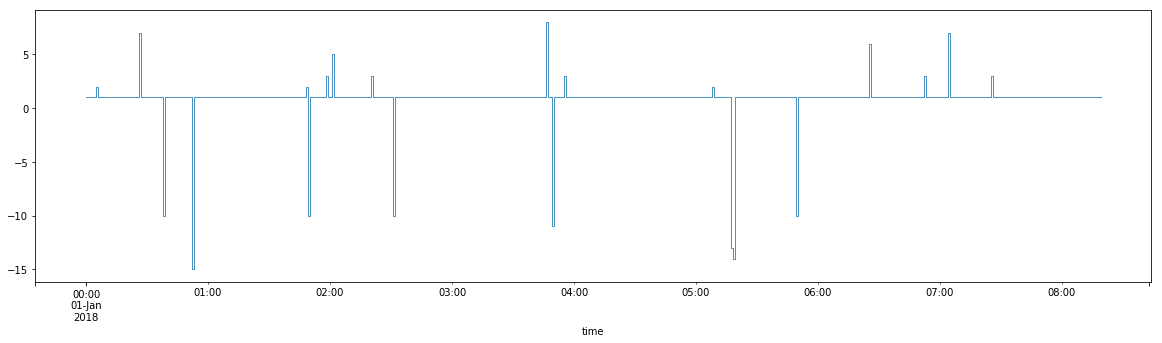

In [26]:
caql_plot("demo", '''

if{
  metric:average("673044d5-379a-4037-89e5-c0694ef756ed","duration") < 10,  // condition
  metric:average("673044d5-379a-4037-89e5-c0694ef756ed","duration"),       // OK pass t data
  -metric:average("673044d5-379a-4037-89e5-c0694ef756ed","duration")       // NOK negative data
}
''', datetime(2018,1,1), 60, 500)

## Multi-stream operations

Most CAQL operations either apply only to a single stream, or aggregate multiple streams into one.
The each package provides functions that operate on all input slots at once.

* each:add(x) - Adds a given amount to all input slots
* each:div(x) - Divides all input slots by a given number
* each:mul(x) - Multiplies all input slots by a given number


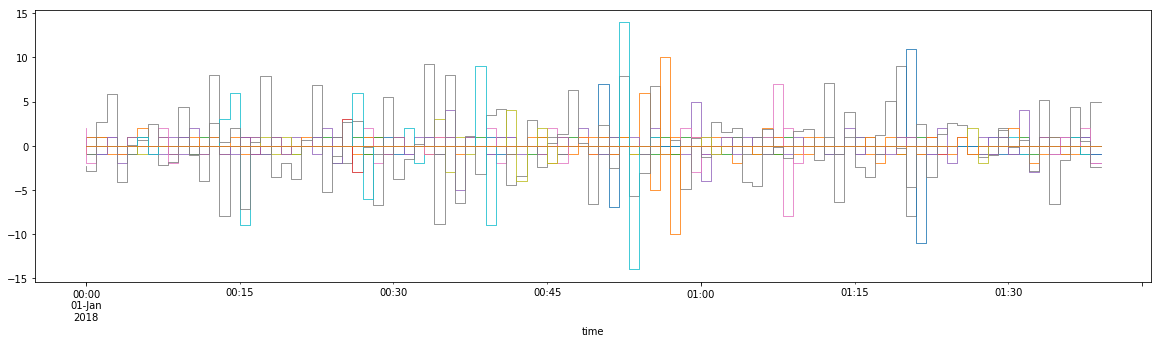

In [89]:
caql_plot('demo', '''

search:metric:derivative("duration") | each:mul(60)

''', datetime(2018,1,1), 60, 100);

## Integrals and Differentials

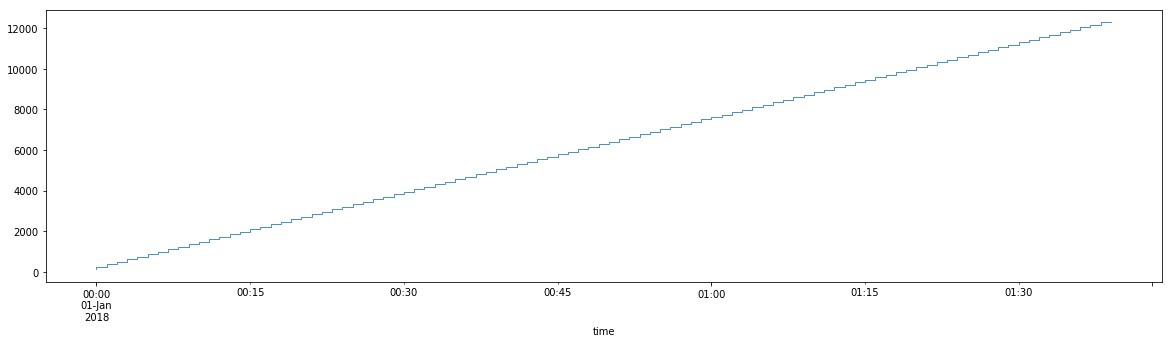

In [26]:
caql_plot('demo', '''

123 | integrate()


''', datetime(2018,1,1), 60, 100)

**CAVEAT:** diff() returns delta per minute (since M are currently the base resolution of CAQL). metric:derivative()/metric:counter() returns the delta per second. They differ by a factor of 60.

## Application: Throughput calculations

Say you want to read-off a graph how much data was trasmitted over the past 1week.
If you are already using the API to pull raw data, you can do that calculation trivially by substracting counters.
If you only have the UI to use, you can use the date-picker and integrate() to arrive at the same conclusion.

Here is how that looks on a graph:
https://nanobyte.circonus.com/trending/graphs/view/151301a5-29de-4d0b-a7d9-eaa5e4de3175

Here is a similar example in notebook form:

Text(0.5,1,'Bytes IN/OUT')

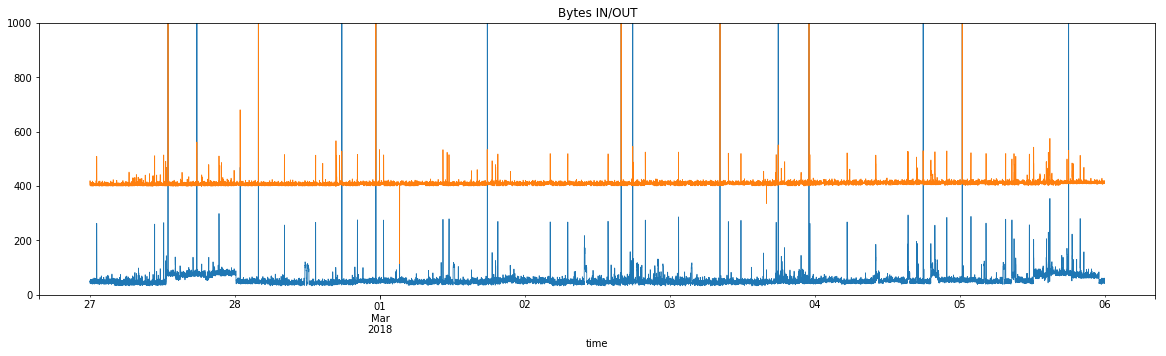

In [42]:
caql_plot('hartmann', '''
pass{
  metric:counter("b6266779-c835-4341-a71b-a250e68d2347","if`enp2s0`in_bytes"),
  metric:counter("b6266779-c835-4341-a71b-a250e68d2347","if`enp2s0`out_bytes")
}
''', datetime(2018,2,27), 60, 60*24*7)
plt.ylim(0, 1000)
plt.title("Bytes IN/OUT")

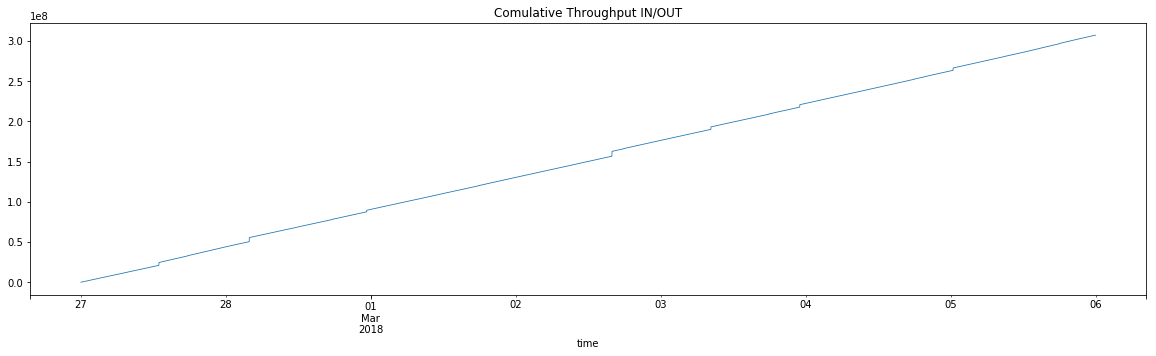

In [73]:
caql_plot('hartmann', '''
pass{
  metric:counter("b6266779-c835-4341-a71b-a250e68d2347","if`enp2s0`in_bytes"),
  metric:counter("b6266779-c835-4341-a71b-a250e68d2347","if`enp2s0`out_bytes")
}
| each:mul(60) // convert bytes/sec to bytes/minue
| stats:sum()  // total throughput
| integrate()  // build comulative sum
''', datetime(2018,2,27), 60, 60*24*7)
plt.title("Comulative Throughput IN/OUT");

## Variant: Rolling 1d-Throughput

How much data was transferred over the last day?

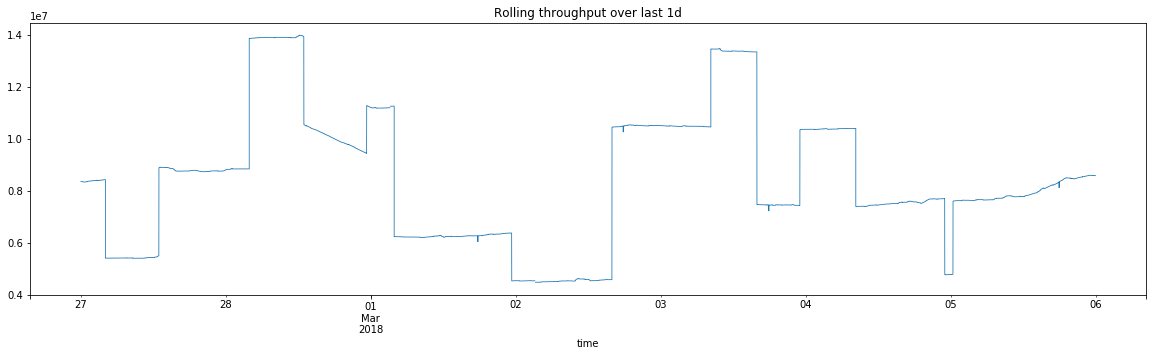

In [77]:
# Lag-ed differences
caql_plot('hartmann', '''
op:sub{
 metric:average("b6266779-c835-4341-a71b-a250e68d2347","if`enp2s0`in_bytes"),
 metric:average("b6266779-c835-4341-a71b-a250e68d2347","if`enp2s0`in_bytes") | delay(1d)
}
''', datetime(2018,2,27), 60, 60*24*7)
plt.title("Rolling throughput over last 1d");

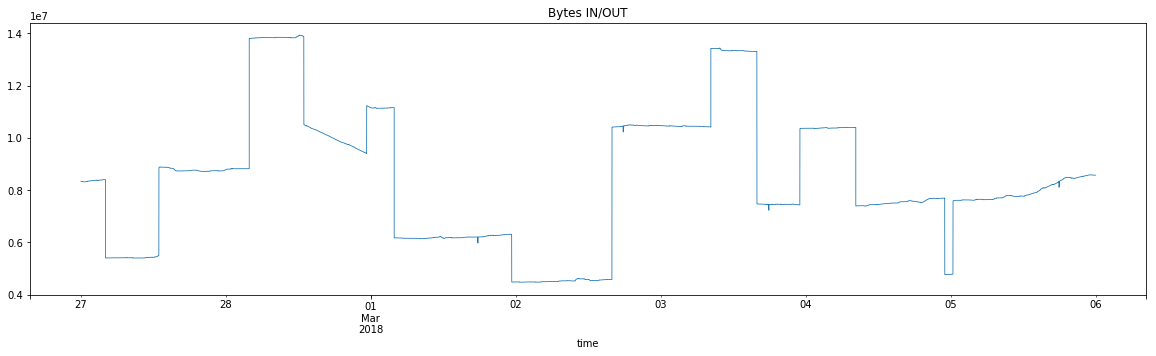

In [76]:
# Rolling sums
caql_plot('hartmann', '''

metric:counter("b6266779-c835-4341-a71b-a250e68d2347","if`enp2s0`in_bytes")
| op:prod(60) // convert to bytes per minute
| rolling:sum(1d)

''', datetime(2018,2,27), 60, 60*24*7)
plt.title("Bytes IN/OUT");

## Smoothing data with Exponential Moving Averages

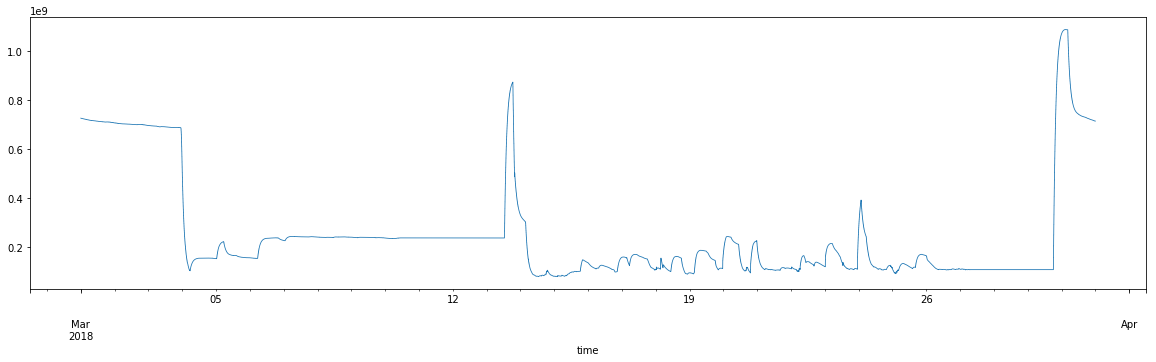

In [97]:
caql_plot('hartmann','''

metric:average('b6266779-c835-4341-a71b-a250e68d2347', 'vm`meminfo`MemFree')
// | rolling:mean(1h)
| forecasting:ewma(0.01)

''', datetime(2018,3,1), 60, 60*24*30)

## Time functions

* time:epoch() -- returns the current epoch in seconds
* time:tz(timezone, field) -- returns timezone information from the tz database

For a list of supported timezones see 

* https://en.wikipedia.org/wiki/List_of_tz_database_time_zones
* https://en.wikipedia.org/wiki/Tz_database

**TODO:** Allow windowing functions to be triggered by tz information. 

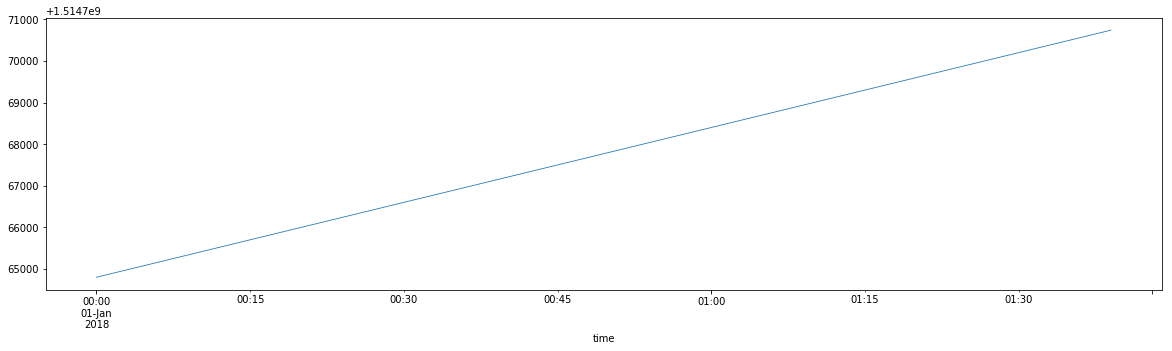

In [35]:
caql_plot('demo', '''

time:epoch()

''', datetime(2018,1,1), 60, 100)

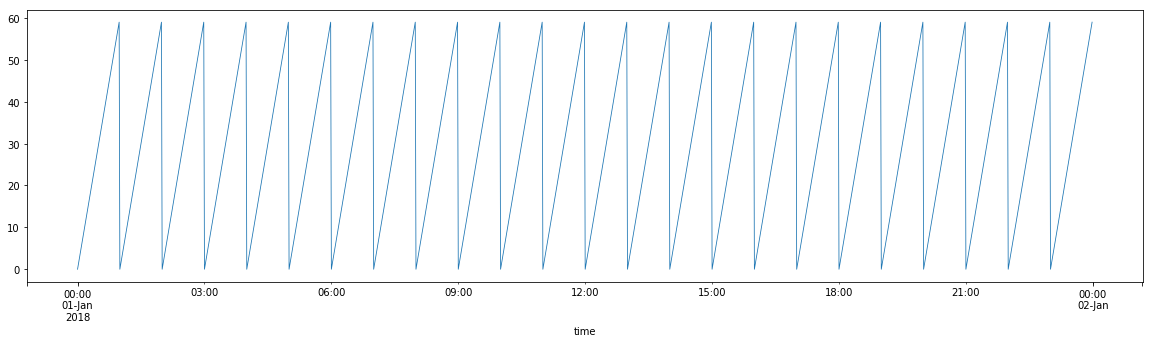

In [36]:
caql_plot('demo', '''

time:tz("UTC","minute")

''', datetime(2018,1,1), 60, 60*24)

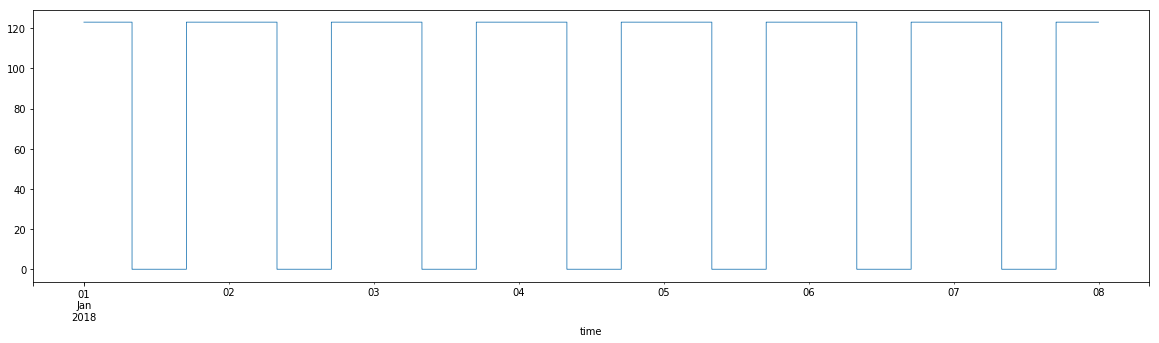

In [30]:
caql_plot('demo', '''

if{ (time:tz("Pacific/Tahiti","hour") < 22) and (time:tz("Pacific/Tahiti","hour") > 6),

123,

0}

''', datetime(2018,1,1), 60, 60*24*7)

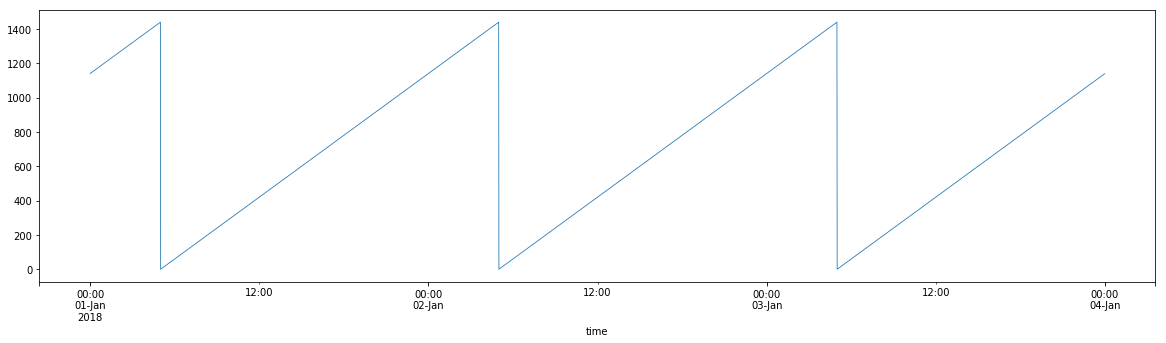

In [38]:
caql_plot('demo', '''

time:tz("US/Eastern","hour") * 60 + time:tz("US/Eastern", "minute")

''', datetime(2018,1,1), 60, 60*24*3)